# AfSIS Soil Chemistry Dataset - Modelling¶



## 1. Load libraries and data

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
from sys import stdout
#from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.ridge import Ridge
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
import xgboost 
from xgboost import XGBRegressor

from sklearn.datasets import make_regression
from sklearn import svm
import numpy as np
import time
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import Image

from sklearn.decomposition import PCA
from scipy.signal import savgol_filter

from sklearn.cross_decomposition import PLSRegression
from sklearn.cross_decomposition import PLSCanonical
from sklearn.cross_decomposition import PLSSVD


from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.ridge module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
df_composition = pd.read_csv('elemental_analysis_dataset.csv')
df_composition = df_composition.rename(columns={"P": "%P", "K": "%K","Ca": "%Ca", "Cu": "%Cu", "Fe": "%Fe", "Mo": "%Mo","Mg": "%Mg","S": "%S","Mn": "%Mn","Zn": "%Zn" , "Cl": "%Cl",})
df_composition.head()

,SSN,pH,%N,%C,C % Inorg,C % Org,Am Ox_Al mg/kg,Am Ox-Fe mg/kg,AmOx-Mn/mg/kg,AmOx-Pmg/kg,...,%Fe,%Mn,%Mo,Public,Latitude,Longitude,Cluster,Plot,Depth,Cultivated
0,icr006454,7.85,0.08,0.95,0.0,0.94,2105.973713,868.347797,160.462825,27.456545,...,1.16865,0.02010,0.01845,True,-6.12601,36.440201,1,1,top,True
1,icr006455,8.03,0.06,0.81,0.1,0.70,2703.686191,1095.670284,185.252606,48.309930,...,1.59154,0.02566,0.01845,True,-6.12601,36.440201,1,1,sub,True
2,icr006474,5.01,0.05,0.57,0.0,0.57,1554.842158,949.235199,52.608644,22.887339,...,0.88799,0.00792,0.01845,True,-6.08875,36.435982,2,1,top,False
3,icr006475,4.57,0.05,0.47,0.0,0.47,1846.889773,1070.019199,33.656658,9.381672,...,1.25013,0.00819,0.01845,True,-6.08875,36.435982,2,1,sub,False
4,icr006492,6.78,0.09,0.98,0.0,0.98,1871.559305,1204.912035,172.634574,32.109882,...,1.48940,0.01938,0.01845,True,-6.06394,36.440500,3,1,top,False


## 2. Elemental analysis and soil fertility

### 2.1 Soil chemistry variables correlation

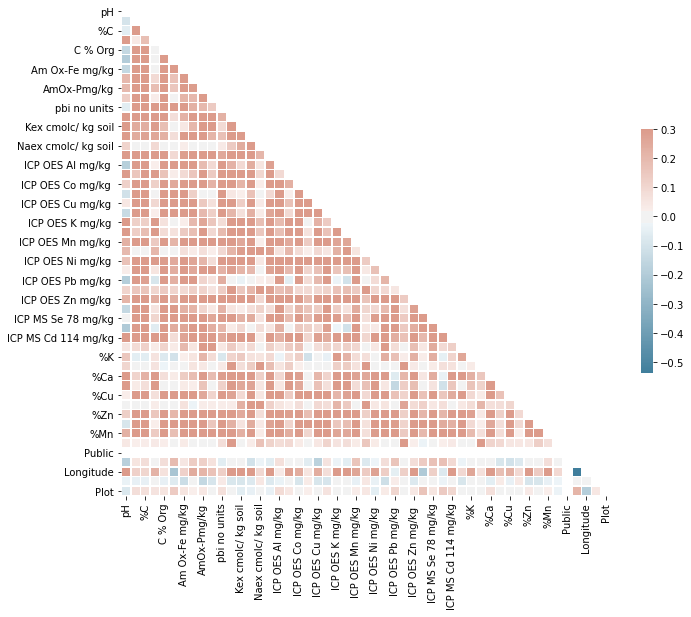

In [4]:
# Compute the correlation matrix
corr = df_composition.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The figures show poor correlation. Surprising that this is true comparing the same element concentration estimated using ICP Optical Emission Spectrometry (ICP-OES-K) and X-rays fluorescence (K)

### 2.2 Composition - fertility correlation

#### 2.2.1 Features selection

In [5]:
elemental_variables = ['pH', '%N', '%P', '%K', '%Ca','%Mg','%S','%Cu','%Mo','%Mn','%Fe', 'Depth', 'Cultivated']
# major and oligoelements are taken into account for the soil composition

df_composition_reduced = df_composition[elemental_variables]

df_composition_reduced.head()

,pH,%N,%P,%K,%Ca,%Mg,%S,%Cu,%Mo,%Mn,%Fe,Depth,Cultivated
0,7.85,0.08,0.00506,1.59260,0.44832,0.55750,0.00457,0.00098,0.01845,0.02010,1.16865,top,True
1,8.03,0.06,0.00506,2.04214,0.90155,0.40326,0.00457,0.00124,0.01845,0.02566,1.59154,sub,True
2,5.01,0.05,0.00506,1.28172,0.08998,0.55750,0.00457,0.00093,0.01845,0.00792,0.88799,top,False
3,4.57,0.05,0.00506,1.29913,0.09441,0.55750,0.00457,0.00130,0.01845,0.00819,1.25013,sub,False
4,6.78,0.09,0.00506,2.21456,0.76517,0.55750,0.00457,0.00144,0.01845,0.01938,1.48940,top,False


#### 2.2.2 Categorical features encoding

In [6]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(sparse=False)# label encoded values of depth
enc_df = pd.DataFrame(enc.fit_transform(df_composition_reduced[['Depth']]), columns = ['depth_sub','depth_top'])

df_composition_reduced = pd.merge(df_composition_reduced, enc_df, left_index=True, right_index=True)
df_composition_reduced = df_composition_reduced.reset_index(drop = True)


In [7]:
df_composition_cultivated  = df_composition_reduced[df_composition_reduced['Cultivated'] != "unknown"]  # eliminate unknown values
print(df_composition_cultivated['Cultivated'].unique())

['True' 'False']


In [8]:
# creating instance of labelencoder for the column "Cultivated"
labelencoder = LabelEncoder()# Assigning numerical values and storing in another column
df_composition_cultivated['Cultivated_n'] = labelencoder.fit_transform(df_composition_cultivated['Cultivated'])

print(df_composition_cultivated.shape)
df_composition_cultivated = df_composition_cultivated.drop(['Depth', 'Cultivated'], axis = 1)

(148, 16)


<ipython-input-8-d4eb68b28776>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_composition_cultivated['Cultivated_n'] = labelencoder.fit_transform(df_composition_cultivated['Cultivated'])


In [9]:
df_composition_cultivated.head()

,pH,%N,%P,%K,%Ca,%Mg,%S,%Cu,%Mo,%Mn,%Fe,depth_sub,depth_top,Cultivated_n
0,7.85,0.08,0.00506,1.59260,0.44832,0.55750,0.00457,0.00098,0.01845,0.02010,1.16865,0.0,1.0,1
1,8.03,0.06,0.00506,2.04214,0.90155,0.40326,0.00457,0.00124,0.01845,0.02566,1.59154,1.0,0.0,1
2,5.01,0.05,0.00506,1.28172,0.08998,0.55750,0.00457,0.00093,0.01845,0.00792,0.88799,0.0,1.0,0
3,4.57,0.05,0.00506,1.29913,0.09441,0.55750,0.00457,0.00130,0.01845,0.00819,1.25013,1.0,0.0,0
4,6.78,0.09,0.00506,2.21456,0.76517,0.55750,0.00457,0.00144,0.01845,0.01938,1.48940,0.0,1.0,0


#### 2.2.3 Data modeling - logistic regression

In [10]:

X_cultivated = df_composition_cultivated.drop(['Cultivated_n'], axis = 1).values[:, 1:]

X_cult_scaled = StandardScaler().fit_transform(X_cultivated) # scale those features
y_cultivated = df_composition_cultivated['Cultivated_n'].values

X1_train, X1_test, y1_train, y1_test = train_test_split(X_cult_scaled, y_cultivated, test_size = 0.2, random_state = 42)

In [11]:
lr_cultivated = LogisticRegression(solver='liblinear',dual=True, random_state=42)

lr_cultivated.fit(X1_train, y1_train)
y1_pred = lr_cultivated.predict(X1_test) # estimation of cultivated value based on fit
accuracy_lr = lr_cultivated.score(X1_test, y1_test)
print('Score of the logistic regression model for soil composition and fertility = ',np.round(accuracy_lr,2))

Score of the logistic regression model for soil composition and fertility =  0.87


/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [12]:
cm1 = confusion_matrix(y1_test, y1_pred)

print(classification_report(y1_test, y1_pred))

df_confusionmatrix1 = pd.DataFrame(data=cm1, index=["actual negative","actual positive"], columns=["predicted negative","predicted positive"])
df_confusionmatrix1 

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        25
           1       0.60      0.60      0.60         5

    accuracy                           0.87        30
   macro avg       0.76      0.76      0.76        30
weighted avg       0.87      0.87      0.87        30



,predicted negative,predicted positive
actual negative,23,2
actual positive,2,3


In [13]:
# Cross-validation
y_cv = cross_val_predict(lr_cultivated, X1_test, y1_test, cv=5)
scores = cross_val_score(lr_cultivated, X1_test, y1_test, cv=5)
scores

array([0.83333333, 0.66666667, 0.83333333, 0.83333333, 0.83333333])

Logistic Regression: 1-dimensional representation


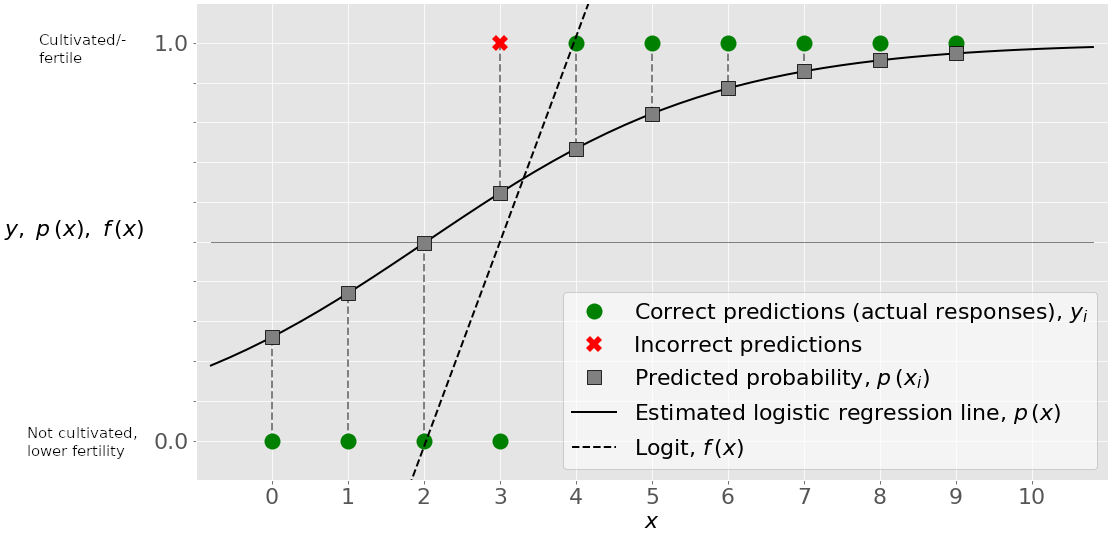

In [14]:
print("Logistic Regression: 1-dimensional representation")
Image(filename='img/logisticregression.png') 

In [15]:
n_components = 5

pca = PCA(n_components= n_components)
principalComponents = pca.fit_transform(X_cult_scaled)

df_PCA_composition = pd.DataFrame(data = principalComponents , columns = ['compositional_component1','compositional_component2','compositional_component3','compositional_component4','compositional_component5'])


print('the new component contains',pca.explained_variance_ratio_ * 100, '% of the information from the', n_components ,'variables', 'for a total of',sum(pca.explained_variance_ratio_ * 100),'%' )
#

the new component contains [30.39960938 18.95856956 16.00332647 11.00627545  8.53062535] % of the information from the 5 variables for a total of 84.89840620844835 %


#### 2.2.4 Data modeling - major elements correlation

The %N cannot be detected by XRF. It is interesting then to predict it by a correlation with major elements

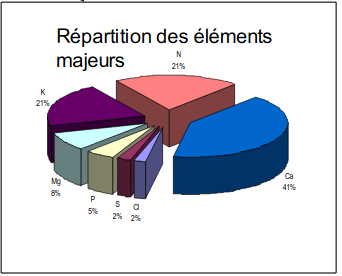

In [16]:
Image(filename='img/majorelements.png')

In [17]:
major_elements = ['%N', '%P', '%K','%Ca','%Mg','%S', '%Cl']
df_composition_major = df_composition[major_elements]
print(df_composition_major.shape)
df_composition_major.head()

(467, 7)


,%N,%P,%K,%Ca,%Mg,%S,%Cl
0,0.08,0.00506,1.59260,0.44832,0.55750,0.00457,0.01162
1,0.06,0.00506,2.04214,0.90155,0.40326,0.00457,0.02007
2,0.05,0.00506,1.28172,0.08998,0.55750,0.00457,0.01177
3,0.05,0.00506,1.29913,0.09441,0.55750,0.00457,0.02102
4,0.09,0.00506,2.21456,0.76517,0.55750,0.00457,0.01033


In [18]:
#Variables selection
X_major = df_composition_major.drop(['%N'], axis = 1).values[:, 1:]

X_maj_scaled = StandardScaler().fit_transform(X_major) # scale those features
y_maj = df_composition_major['%N'].values

X0_train, X0_test, y0_train, y0_test = train_test_split(X_maj_scaled, y_maj, test_size = 0.2, random_state = 42)

Multilinear regression

In [19]:
reg = LinearRegression()
reg.fit(X0_train, y0_train)

y0_pred = reg.predict(X0_test)

multilinear_r2 = r2_score(y0_test,y0_pred)


# Calculate mean squared error for the regression
multilinear_mse = mean_squared_error(y0_test, y0_pred)

print('R2: %5.3f'  % multilinear_r2)

print('MSE: %5.3f' % multilinear_mse)

R2: -0.004
MSE: 0.006


XGBoost

In [20]:
#kfold = KFold(shuffle=True, random_state=0, n_splits=4)
xgb = XGBRegressor(n_estimators=500, min_child_weight=20, n_jobs=-1, objective='reg:squarederror')

xgb.fit(X0_train, y0_train)

y_pred_xgb = xgb.predict(X0_test)#.reshape(1, 1))

# Calculate scores for the regression
xgb_score = r2_score(y0_test, y_pred_xgb)

# Calculate mean squared error for the regression
xgb_mse = mean_squared_error(y0_test, y_pred_xgb)

print('R2: %5.3f'  % xgb_score)

print('MSE: %5.3f' % xgb_mse)

R2: -0.225
MSE: 0.007


Random Forest

In [21]:
rf = RandomForestRegressor(max_depth=20, random_state=42)
rf.fit(X0_train, y0_train)

y_pred_rf = rf.predict(X0_test)#.reshape(1, 1))

# Calculate scores for the regression
rf_score = r2_score(y0_test, y_pred_rf)

# Calculate mean squared error for the regression
rf_mse = mean_squared_error(y0_test, y_pred_rf)

print('R2: %5.3f'  % rf_score)

print('MSE: %5.3f' % rf_mse)

R2: 0.075
MSE: 0.005


Poor correlation between elements concentration

## 3. Elemental analysis - Infrared spectroscopy correlation

### 3.1 Loading mid-infrared spectra and target variables

In [22]:
df_FTIR = pd.read_csv('middle_infrared_spectra_dataset.csv')


(467, 2542)


In [23]:
# Get wavelengths
wavelenghts_list = df_FTIR_sp.columns.tolist() 
wavelenghts = np.array(wavelenghts_list)
print(len(wavelenghts))


2542


In [24]:
X = df_FTIR_sp.values

##### Targets selection

In [25]:
# single target regression
target_feature = 'C % Org' #['C % Org', '%P', '%K']#, '%Ca', '%Cu', '%Fe', '%Mo','pH'
# multiple targets regression
target_features = ['%N', 'C % Org', 'pH']#, '%Ca', '%Cu', '%Fe', '%Mo','pH']

y2 = df_composition[target_feature].values #PLS1 - single feature regression
Y2 = df_composition[target_features].values #PLS2 - multiple features regression
print('shapes verification',y2.shape, Y2.shape)

shapes verification (467,) (467, 3)


In [26]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size = 0.2, random_state = 42)

### 3.2 Multivariate linear regression

In [27]:
lr = LinearRegression()

lr_model = lr.fit(X2_train,y2_train)

y_lr = lr.predict(X2_test)  
r2_lr = r2_score(y2_test, y_lr)
mse_lr = mean_squared_error(y2_test, y_lr)
print('linear regression R²',r2_lr )
print('linear regression MSE',mse_lr )

linear regression R² -7.171783391323487
linear regression MSE 9.68750318001591


Text(0.5, 1.0, 'Multivariate linear regression')

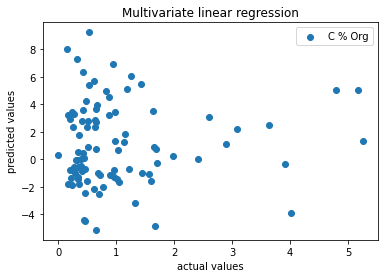

In [28]:
plt.scatter(y2_test, y_lr, label = target_feature)
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('Multivariate linear regression')

### 3.4 Ridge regression

In [29]:
parameters = {'alpha':np.logspace(-4, -3.5, 50)}
#Run a Grid search, using R^2 as the metric to optimise alpha
ridge= GridSearchCV(Ridge(), parameters, scoring='r2', cv=10)
# Fit to the data
ridge.fit(X2_train, y2_train)
# Run a ridge regression with the optimised value
print('Best parameter alpha = ', ridge.best_params_['alpha'])

y_ridge = ridge.predict(X2_test)  
#Get the optimised value of alpha

print('ridge regression R² : %5.3f'  % ridge.score(X2_train, y2_train))
mse_ridge = mean_squared_error(y2_test, y_ridge)
print('ridge regression MSE',mse_ridge )

Best parameter alpha =  0.00031622776601683794
ridge regression R² : 0.991
ridge regression MSE 6.927639694570894


Text(0.5, 1.0, 'Ridge regression')

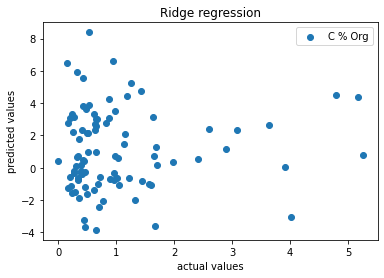

In [30]:
plt.scatter(y2_test, y_ridge, label = target_feature)
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('Ridge regression')

### 3.3 Random forest regression

In [31]:

X2, y2 = make_regression(n_features=len(wavelenghts), n_informative=150,random_state=0, shuffle=False)

rf = RandomForestRegressor(max_depth=20, random_state=42)
rf.fit(X2_train, y2_train)
y_pred_rf = rf.predict(X2_test)#.reshape(1, 1))

# Calculate scores for calibration and cross-validation
rf_score_c = r2_score(y2_test, y_pred_rf)

# Calculate mean squared error for calibration and cross validation
rf_mse_c = mean_squared_error(y2_test, y_pred_rf)

print('random forest regression R²: %5.3f'  % rf_score_c)

print('random forest regression MSE: %5.3f' % rf_mse_c)


random forest regression R²: -0.212
random forest regression MSE: 1.437


Text(0.5, 1.0, 'Random forest regression')

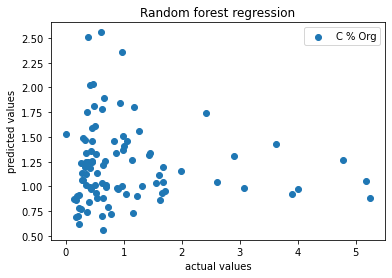

In [32]:
plt.scatter(y2_test, y_pred_rf, label = target_feature)
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('Random forest regression')

### 3.2 Multivariate partial least squares (PLS) regression
#### PLS1: univariate target 

NIR spectra should be correlated to COH elements, i.e. organic carbon and we investigate the correlation between these data with multivariate partial least squares regression. The predicting variables are the FTIR wavelenghts. The target is % organic C. 


In [33]:
# what is the optimal number of latent predictive features?
n_comp = 30
mse = []
r2 = []
component = np.arange(1, n_comp,2)
    
for i in component:
    pls = PLSRegression(n_components=i)
    model = pls.fit(X2_train, y2_train)
    
    y_c = model.predict(X2_test)

    mse.append(mean_squared_error(y2_test, y_c))
    r2.append(r2_score(y2_test, y_c))

Text(0.5, 0, 'Number of PLS components')

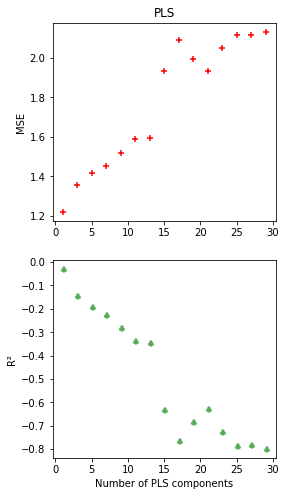

In [34]:
plt.figure(figsize= (4,8))
plt.subplot(211)
plt.scatter(component, mse, label = 'mse', marker = '+', c='r')
plt.title('PLS')
plt.ylabel('MSE')

plt.subplot(212)
plt.scatter(component, r2, label = 'R²', alpha=0.5, marker=r'$\clubsuit$', c='g')
plt.ylabel('R²')
plt.xlabel('Number of PLS components')

Now let's run this function by setting the optimized mumber of components.

In [35]:
pls = PLSRegression(n_components=10)
model_pls = pls.fit(X2_train, y2_train)

y_c = model_pls.predict(X2_test)


# Calculate scores for calibration and cross-validation
score_c = r2_score(y2_test, y_c)



# Calculate mean squared error for calibration and cross validation
mse_c = mean_squared_error(y2_test, y_c)

print('PLS R²: %5.3f'  % score_c)

print('PLS MSE: %5.3f' % mse_c)

PLS R²: -0.285
PLS MSE: 1.524


Text(0.5, 1.0, 'PLS regression')

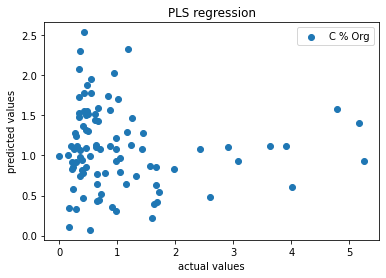

In [36]:
plt.scatter(y2_test, y_c, label = target_feature)
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('PLS regression')

- PLS canonical

In [37]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X, Y2, test_size = 0.2, random_state = 42)

In [38]:
print('n targets: ',len(target_features))

plsca = PLSCanonical(n_components= len(target_features))
model_pls_canonical = plsca.fit(X2_train, Y2_train)
X_c, Y_c = plsca.transform(X2_test, Y2_test)



n targets:  3


In [39]:

# Calculate scores for calibration and cross-validation
plsca_score_c = r2_score(Y2_test, Y_c)

# Calculate mean squared error for calibration and cross validation
plsca_mse_c = mean_squared_error(Y2_test, Y_c)


print('R² score',target_features[0],': ',r2_score(Y2_test[:,0], Y_c[:,0]))
print('R² score',target_features[1],': ',r2_score(Y2_test[:,1], Y_c[:,1]))
print('R² score',target_features[2],': ',r2_score(Y2_test[:,2], Y_c[:,2]))
print('')
print('R² PLS Canonical average: %5.3f'  % plsca_score_c)

print('MSE PLS Canonical average: %5.3f' % plsca_mse_c)


R² score %N :  -243.2557154718495
R² score C % Org :  -1.2698212943594664
R² score pH :  -26.83110461310481

R² PLS Canonical average: -90.452
MSE PLS Canonical average: 13.487


[]

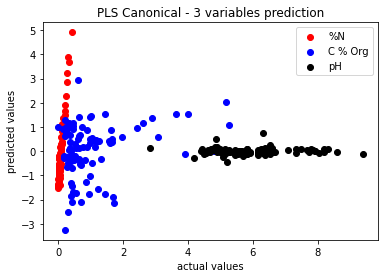

In [40]:
plt.scatter(Y2_test[:,0], Y_c[:,0], label = target_features[0], color = 'r')
plt.scatter(Y2_test[:,1], Y_c[:,1], label = target_features[1], color = 'b')
plt.scatter(Y2_test[:,2], Y_c[:,2], label = target_features[2], color = 'k')
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('PLS Canonical - 3 variables prediction')
plt.plot()

## 4. Model improvements strategies

PLS did not give so good results as expected from this academic paper

https://www.sciencedirect.com/science/article/abs/pii/S0016706119302368

Possibly the procedure can be optimized.

### 4.1 FTIR spectra baseline correction by differentiation

(467, 2542)


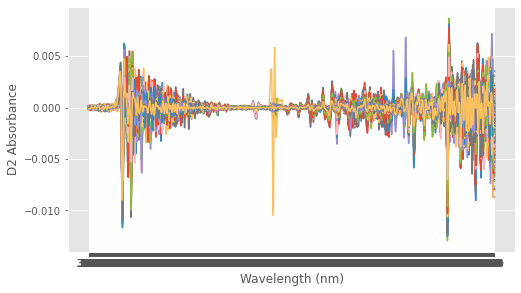

In [41]:
# Calculate second derivative. That should average baselines
X2 = savgol_filter(X, 17, polyorder = 2,deriv=2)
print(X2.shape)
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wavelenghts, X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Absorbance')
    plt.show()

In [42]:
y2 = df_composition[target_feature].values
X3_train, X3_test, y3_train, y3_test = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

pls = PLSRegression(n_components=10)
model_pls = pls.fit(X3_train, y3_train)

y3_c = model_pls.predict(X3_test)


# Calculate scores for calibration and cross-validation
score3_c = r2_score(y3_test, y3_c)



# Calculate mean squared error for calibration and cross validation
mse3_c = mean_squared_error(y3_test, y3_c)

print('PLS R² after spectra differentiation: %5.3f'  % score3_c,'vs.',score_c,'for primitive wave functions')

print('PLS MSE after spectra differentiation: %5.3f' % mse3_c,'vs.',mse_c,'for primitive wave functions')

PLS R² after spectra differentiation: -1.759 vs. -0.2852857898274508 for primitive wave functions
PLS MSE after spectra differentiation: 3.271 vs. 1.523683335684466 for primitive wave functions


Text(0.5, 1.0, 'PLS regression for FTIR derivative function')

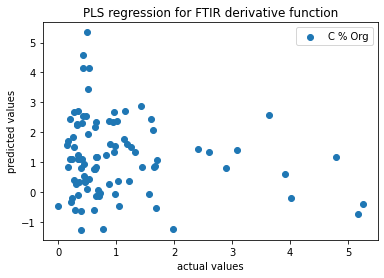

In [43]:
plt.scatter(y3_test, y3_c, label = target_feature)
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('PLS regression for FTIR derivative function')

### 4.2 FTIR spectra reduction

I select only the regions containing the peaks corresponding to C=O and C=C bonds and filter away the rest of the spectrum containing either a flat or a noisy curve

In [100]:
print(df_FTIR.shape)
df_FTIR_reindex = df_FTIR.set_index('SSN')
FTIR_spectra = df_FTIR_reindex.T.reset_index()
FTIR_spectra = FTIR_spectra.rename(columns={'index': 'labda'})

print(FTIR_spectra.shape)
FTIR_spectra.head()

(467, 2543)
(2542, 468)


SSN,labda,icr033603,icr074337,icr048665,icr015592,icr074691,icr074413,icr048642,icr006510,icr049735,...,icr075529,icr073208,icr055982,icr070263,icr021023,icr075757,icr041916,icr074470,icr041699,icr037699
0,3998,0.908592,1.065667,0.841665,0.763867,0.667032,0.999511,0.908099,0.814602,0.857259,...,0.778946,0.823722,0.808334,0.789542,0.726638,0.802907,0.898819,0.792397,0.819836,0.792272
1,3997,0.908981,1.066403,0.842381,0.763912,0.667626,1.002429,0.909043,0.815387,0.857547,...,0.779014,0.824720,0.808043,0.789980,0.727226,0.803286,0.899391,0.793097,0.820663,0.793356
2,3996,0.909435,1.067118,0.842883,0.764111,0.668246,1.004935,0.910022,0.816195,0.857735,...,0.779148,0.825583,0.807701,0.790511,0.727759,0.803656,0.900354,0.793904,0.821373,0.794496
3,3994,0.909956,1.067661,0.843214,0.764360,0.668855,1.006428,0.911050,0.816989,0.857855,...,0.779399,0.826253,0.807525,0.791108,0.728201,0.804023,0.901748,0.794826,0.821845,0.795609
4,3993,0.910562,1.067915,0.843479,0.764543,0.669406,1.006630,0.912146,0.817741,0.857935,...,0.779775,0.826709,0.807697,0.791700,0.728530,0.804414,0.903499,0.795807,0.822042,0.796670


In [101]:
FTIR_spectra = pd.read_csv('MIR_spectra_transposed.csv')

In [102]:
print(len(FTIR_spectra.labda))

2542


FTIR spectrum example


Text(0.5, 0, 'Wavelengths (cm-1)')

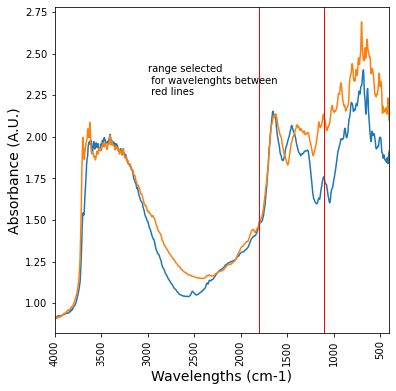

In [109]:
wavelenght_lower_limit = 1100
wavelenght_upper_limit = 1800
print('FTIR spectrum example')
plt.figure(figsize= (6,6))

 
plt.plot(FTIR_spectra['labda'],FTIR_spectra['icr033603'])
plt.plot(FTIR_spectra['labda'],FTIR_spectra['icr048642'])
plt.axvline(x=1800 , ymin=0, ymax=1, color='r', linewidth = 1)
plt.axvline(x=1100, ymin=0, ymax=1, color='r', linewidth = 1)
plt.text(3000, 2.25, 'range selected \n for wavelenghts between \n red lines')
plt.xticks(rotation=90)
plt.xlim(4000,400)
plt.ylabel('Absorbance (A.U.)', fontsize=14)
plt.xlabel('Wavelengths (cm-1)', fontsize = 14)

Text(0.5, 0, 'Wavelengths (cm-1)')

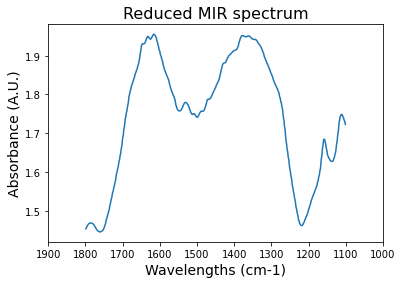

In [111]:
df_MIR_FTIRspectra =  FTIR_spectra[FTIR_spectra['labda'] > wavelenght_lower_limit]  
df_MIR_FTIRspectra = df_MIR_FTIRspectra[df_MIR_FTIRspectra['labda'] < wavelenght_upper_limit] 

plt.plot(df_MIR_FTIRspectra['labda'],df_MIR_FTIRspectra['icr042897']) 
plt.xlim( wavelenght_upper_limit+100,wavelenght_lower_limit-100)
plt.title('Reduced MIR spectrum', fontsize=16)
plt.ylabel('Absorbance (A.U.)', fontsize=14)
plt.xlabel('Wavelengths (cm-1)', fontsize = 14)

In [112]:
df_FTIR_reindexed = df_MIR_FTIRspectra.set_index('labda')
mid_infrared_df = df_FTIR_reindexed.T.reset_index()
mid_infrared_df = mid_infrared_df.rename(columns={'index': 'SSN'})

In [113]:
sampleslist = df_composition['SSN'].tolist()
print('before selection',mid_infrared_df.shape)
mid_infrared_df = mid_infrared_df[mid_infrared_df['SSN'].isin(sampleslist)]
print('after selection',mid_infrared_df.shape)
mid_infrared_df = mid_infrared_df.drop(['SSN'], axis = 1)

before selection (1888, 495)
after selection (467, 495)


In [114]:
X4 = mid_infrared_df.values
y4 = df_composition[target_feature].values

print(X4.shape, y4.shape)

(467, 494) (467,)


In [115]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = 0.2, random_state = 42)

pls = PLSRegression(n_components=10)
model_pls = pls.fit(X4_train, y4_train)

y4_c = model_pls.predict(X4_test)


# Calculate scores for calibration and cross-validation
score4_c = r2_score(y4_test, y4_c)



# Calculate mean squared error for calibration and cross validation
mse4_c = mean_squared_error(y4_test, y4_c)

print('PLS R² after spectra reduction: %5.3f'  % score4_c,'vs.',score_c,'for full spectra')

print('PLS MSE after spectra reduction: %5.3f' % mse4_c,'vs.',mse_c,'for full spectra')

PLS R² after spectra reduction: -0.321 vs. -0.2852857898274508 for full spectra
PLS MSE after spectra reduction: 1.567 vs. 1.523683335684466 for full spectra
